<a href="https://colab.research.google.com/github/buzhangjiuzhou/DLfinal/blob/master/bert_AGnews_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# 导入包
# transformer提供了一些训练好的模型，可以很方便的使用。
!pip install transformers
import tensorflow as tf
import pandas as pd
import os
import tqdm
# 使用分类的模型，增加了一个head用于分类。
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
% matplotlib inline

tf.__version__

'2.2.0'

In [24]:
# 导入现成的模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4) # 分类类别数
model.summary()
model.config

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier', 'dropout_75']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3076      
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0
_________________________________________________________________


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [25]:
# 简单分类算法
model_compare = tf.keras.Sequential([
    tf.keras.layers.Embedding(30522, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4)
])
model_compare.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          1953408   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 2,027,972
Trainable params: 2,027,972
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 数据链接，可以在 https://course.fast.ai/datasets 找到。
# agnews数据集，类别，标题，描述。
ag_url = 'https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz'

In [27]:
# 下载数据，并指定此时数据集的目录
ag_zip_file = tf.keras.utils.get_file(origin=ag_url,fname='ag_news_csv.tgz', extract=True)
base_dir = os.path.join(os.path.dirname(ag_zip_file), 'ag_news_csv')
os.listdir(base_dir)

['readme.txt', 'classes.txt', 'test.csv', 'train.csv']

In [28]:
# 读取数据
# 为了方便测试代码的时候少用几个数据,1000个数据可以让准确率上升到0.68
num = 1000
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), header=None)
train = train.sample(n=num)
print(len(train))
print(train.head())
test = pd.read_csv(os.path.join(base_dir, 'test.csv'), header=None)
test = test.sample(n=num)
print(len(test))
print(test.head())
f = open(os.path.join(base_dir, 'classes.txt'))
classes = f.readlines()
classes = [s.strip() for s in classes]
print(classes)

1000
       0  ...                                                  2
7443   3  ...   DETROIT (Reuters) - General Motors Corp. is r...
88272  4  ...  In the night of 15-16 November, ESA #39;s Smar...
48697  1  ...  As U.S. and Iraqi troops patrolled the battere...
95840  3  ...  What a mess. Weeks after Merck  amp; Co. (MRK ...
28791  1  ...  Reuters - Director George Butler says he hasn'...

[5 rows x 3 columns]
1000
      0  ...                                                  2
3012  4  ...  Did you know that the Earth is constantly humm...
951   4  ...  We spotlight people and products that pester u...
1854  4  ...  Iomega Corp. is soon expected to ship its firs...
945   2  ...  Who would have thought that the Dallas Cowboys...
7440  4  ...  As the holidays approach, Christmas spirit is ...

[5 rows x 3 columns]
['World', 'Sports', 'Business', 'Sci/Tech']


In [29]:
# transformers自带的tokenizer中的encoder会把一段文本进行编码，然后增加上CLS和SEP，其中CLS的id是101，SEP的编码是102,PAD是0。
# 所以  a   dog   is  not   a   table
# [cls]  a   dog   is  not   a   table  [sep]
# 101   1037  3899  2003 2025  1037  2795   102   0  0  0  ...  0 
# %pprint #让列表横过来，好看一些。
# tokenizer.encode(text='a dog is not a table', padding='max_length',max_length=512)[:20]

In [32]:
# 预处理数据
# 按照上面的例子把数据集中的文本进行分词处理，并且得到对应的labels。
max_length = 256
max_length_temp = max_length - 2
train_ids = []
test_ids = []
for i in tqdm.notebook.trange(train.shape[0]):
  if len(train[2][train[2].index[i]]) > max_length_temp:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
for i in tqdm.notebook.trange(test.shape[0]):
  if len(test[2][test[2].index[i]]) > max_length_temp:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
train_labels = train[0].values - 1
test_labels = test[0].values - 1

In [33]:
# 把数据转成tensorflow张量
# train_ids是tf.Tensor组成得列表，所以用concat组合一下就行
train_ids = tf.concat(train_ids, 0)
# 把train_mask初始化为1，然后把train_ids等于0（PAD的部分）对应的值赋为0
train_mask = tf.ones(train_ids.shape)
train_mask = tf.where(tf.math.greater(train_ids, 0), train_mask, 0)
# labels本身是numpy数组，转为tf.Tensor
train_labels = tf.convert_to_tensor(train_labels)

# 测试集的处理同理test
test_ids = tf.concat(test_ids, 0)
test_mask = tf.ones(test_ids.shape)
test_mask = tf.where(tf.math.greater(test_ids, 0), test_mask, 0)
test_labels = tf.convert_to_tensor(test_labels)

In [34]:
print(train_ids[0])
print(train_mask[0])
print(train_labels[0])

tf.Tensor(
[  101  5626  1006 26665  1007  1011  2236  9693 13058  1012  2003 21195
  2062  2084  3590  1010  2199  1997  2049 14724 13642  2080  4942  9006
 19498  2102  3765  2138  1997  1037  4022  3291  2007  2037  4373  2835
  3808 18000  1012   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [50]:
# 训练参数
epochs = 10
batch_size = 16
validation_rate = 0.1

In [51]:
# 模型编译
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model_compare.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [52]:
# 模型训练
history = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=None,
    #  validation_split=validation_rate, 
    #  validation_data=None, 
     shuffle=True)

Epoch 1/10
63/63 [==============================] - 54s 859ms/step - loss: 0.1932 - accuracy: 0.9390
Epoch 2/10
63/63 [==============================] - 53s 848ms/step - loss: 0.0891 - accuracy: 0.9770
Epoch 3/10
63/63 [==============================] - 54s 850ms/step - loss: 0.0473 - accuracy: 0.9880
Epoch 4/10
63/63 [==============================] - 54s 850ms/step - loss: 0.0257 - accuracy: 0.9950
Epoch 5/10
63/63 [==============================] - 54s 850ms/step - loss: 0.0158 - accuracy: 0.9950
Epoch 6/10
63/63 [==============================] - 53s 848ms/step - loss: 0.0086 - accuracy: 0.9980
Epoch 7/10
63/63 [==============================] - 53s 848ms/step - loss: 0.0106 - accuracy: 0.9990
Epoch 8/10
63/63 [==============================] - 53s 847ms/step - loss: 0.0063 - accuracy: 0.9990
Epoch 9/10
63/63 [==============================] - 53s 848ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 10/10
63/63 [==============================] - 53s 848ms/step - loss: 0.0013 - accura

In [54]:
history_compare = model_compare.fit(
    x=[train_ids, train_mask],
    y=train_labels,
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1,
    callbacks=None,
    shuffle=True
)

Epoch 1/10
63/63 [==============================] - 2s 35ms/step - loss: 1.3856 - accuracy: 0.6006
Epoch 2/10
63/63 [==============================] - 2s 34ms/step - loss: 1.3824 - accuracy: 0.2770
Epoch 3/10
63/63 [==============================] - 2s 33ms/step - loss: 1.3796 - accuracy: 0.2860
Epoch 4/10
63/63 [==============================] - 2s 33ms/step - loss: 1.3752 - accuracy: 0.2770
Epoch 5/10
63/63 [==============================] - 2s 33ms/step - loss: 1.3664 - accuracy: 0.2770
Epoch 6/10
63/63 [==============================] - 2s 33ms/step - loss: 1.3457 - accuracy: 0.4200
Epoch 7/10
63/63 [==============================] - 2s 33ms/step - loss: 1.3100 - accuracy: 0.4270
Epoch 8/10
63/63 [==============================] - 2s 33ms/step - loss: 1.2438 - accuracy: 0.5340
Epoch 9/10
63/63 [==============================] - 2s 33ms/step - loss: 1.1004 - accuracy: 0.5270
Epoch 10/10
63/63 [==============================] - 2s 33ms/step - loss: 1.0540 - accuracy: 0.5480


In [55]:
# 模型测试
model.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=4, 
        verbose=1)

250/250 [==============================] - 19s 74ms/step - loss: 0.5857 - accuracy: 0.8920


[0.5856884121894836, 0.8920000195503235]

In [56]:
model_compare.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=4, 
        verbose=1)

250/250 [==============================] - 2s 8ms/step - loss: 1.1645 - accuracy: 0.4650


[1.1644525527954102, 0.4650000035762787]

In [61]:
# 画图
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.show()

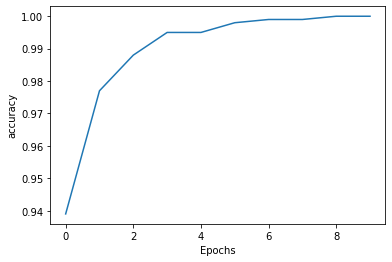

In [62]:
plot_graphs(history, 'accuracy')

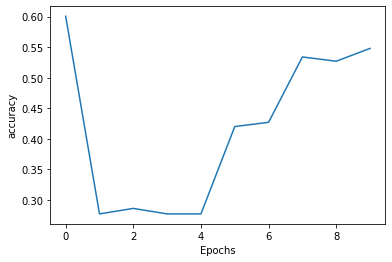

In [63]:
plot_graphs(history_compare, 'accuracy')

In [ ]:
# 准确率

In [ ]:
# 参数的影响

In [ ]:
# 类表征的余弦相似性

In [ ]:
# t-SNE分析